# 1. 商品类别关联规则挖掘：

- 分析用户在同一订单中购买的不同商品类别之间的关联关系
- 找出支持度（support）≥ 0.02、置信度（confidence）≥ 0.5的频繁项集和关联规则
- 特别关注电子产品与其他类别之间的关联关系

In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
from ast import literal_eval
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# 时间统计工具
from time import time

def log_time(step_name):
    def decorator(func):
        def wrapper(*args, **kwargs):
            print(f"\n[START] {step_name}...")
            t0 = time()
            result = func(*args, **kwargs)
            t1 = time()
            print(f"[END] {step_name} in {t1 - t0:.2f} seconds")
            return result
        return wrapper
    return decorator


In [3]:
# 1. 加载 & 合并 parquet 数据
@log_time("Loading and merging Parquet files")
def load_all_parquets(parquet_dir="./30G_data_new_partial"):
    files = glob(os.path.join(parquet_dir, "*.parquet"))
    dfs = [pd.read_parquet(f) for f in files]
    return pd.concat(dfs, ignore_index=True)

df = load_all_parquets()
print("Data shape:", df.shape)



[START] Loading and merging Parquet files...
[END] Loading and merging Parquet files in 86.51 seconds
Data shape: (135000000, 6)


In [4]:
# print(df)
print(df['categories'].head().apply(type))

0    <class 'numpy.ndarray'>
1    <class 'numpy.ndarray'>
2    <class 'numpy.ndarray'>
3    <class 'numpy.ndarray'>
4    <class 'numpy.ndarray'>
Name: categories, dtype: object


In [5]:
# 2. 处理 categories 字段
@log_time("Preprocessing 'categories' field")
def preprocess_categories(df):
    # 将 numpy.ndarray 转为 list
    def to_list(x):
        if isinstance(x, np.ndarray):
            return x.tolist()
        elif isinstance(x, list):
            return x
        elif isinstance(x, str):
            try:
                val = literal_eval(x)
                return val if isinstance(val, list) else None
            except:
                return None
        else:
            return None

    df['categories'] = df['categories'].apply(to_list)

    # 保留长度 >= 2 的列表
    df = df[df['categories'].apply(lambda x: isinstance(x, list) and len(x) >= 2)]

    return df

df = preprocess_categories(df)
print("After filtering, data shape:", df.shape)



[START] Preprocessing 'categories' field...


[END] Preprocessing 'categories' field in 164.32 seconds
After filtering, data shape: (107997513, 6)


In [6]:
print(df.head(5))
print(df.head(10)['categories'])

   avg_price                    categories  category_number payment_method  \
0       7847             [笔记本电脑, 零食, 智能手机]                3            支付宝   
1       7561  [智能手机, 婴儿用品, 儿童课外读物, 模型, 玩具]                5             现金   
4       2542       [平板电脑, 裤子, 调味品, 耳机, 水产]                5            云闪付   
5       3981    [益智玩具, 文具, 蛋奶, 婴儿用品, 平板电脑]                5           微信支付   
6       4357                [帽子, 米面, 床上用品]                3             银联   

  payment_status purchase_date  
0           部分退款    2023-05-05  
1           部分退款    2022-01-29  
4            已支付    2020-07-21  
5           部分退款    2023-08-04  
6            已退款    2022-09-06  
0                [笔记本电脑, 零食, 智能手机]
1     [智能手机, 婴儿用品, 儿童课外读物, 模型, 玩具]
4          [平板电脑, 裤子, 调味品, 耳机, 水产]
5       [益智玩具, 文具, 蛋奶, 婴儿用品, 平板电脑]
6                   [帽子, 米面, 床上用品]
7          [音响, 儿童课外读物, 笔记本电脑, 水产]
9                   [围巾, 蔬菜, 婴儿用品]
10                    [办公用品, 汽车装饰]
12                        [内衣, 相机]
14              [智

In [ ]:
@log_time("FP-Growth mining")
def mine_frequent_itemsets_and_rules(transactions, min_support=0.02, min_confidence=0.5, top_k=20):
    print(f"[INFO] Mining with min_support={min_support}, min_confidence={min_confidence}")
    
    te = TransactionEncoder()
    te_ary = te.fit_transform(transactions)
    df_te = pd.DataFrame(te_ary, columns=te.columns_)

    # Step 1: Frequent Itemsets
    frequent_itemsets = fpgrowth(df_te, min_support=min_support, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)
    frequent_itemsets['support_count'] = (frequent_itemsets['support'] * len(df_te)).astype(int)

    print(f"  Found {len(frequent_itemsets)} frequent itemsets")

    # 打印 Top-K 所有（含单项）频繁项集（可选）
    print(f"\nTop-{top_k} frequent itemsets (by support count):")
    top_itemsets = frequent_itemsets.sort_values(by="support_count", ascending=False).head(top_k)
    for _, row in top_itemsets.iterrows():
        print(f"{list(row['itemsets'])}: {row['support_count']}")
    frequent_itemsets.to_csv("frequent_itemsets_all.csv", index=False)

    # 🔍 打印 Top-K 非单项频繁项集
    multi_itemsets = frequent_itemsets[frequent_itemsets['length'] >= 2]
    top_multi_itemsets = multi_itemsets.sort_values(by="support_count", ascending=False).head(top_k)
    print(f"\nTop-{top_k} frequent itemsets with ≥2 items (by support count):")
    for _, row in top_multi_itemsets.iterrows():
        print(f"{list(row['itemsets'])}: {row['support_count']}")
    multi_itemsets.to_csv("frequent_itemsets_multi.csv", index=False)

    # Step 2: Association Rules
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    rules["lift"] = rules["lift"].round(3)
    rules["confidence"] = rules["confidence"].round(3)
    rules["support"] = rules["support"].round(3)

    if rules.empty:
        print(f"\nNo rules found with confidence ≥ {min_confidence}. Showing Top-{top_k} rules without filtering...")
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.0)
        rules = rules.sort_values(by="confidence", ascending=False).head(top_k)
    else:
        print(f"\nGenerated {len(rules)} rules")
        rules = rules.sort_values(by="confidence", ascending=False).head(top_k)

    # 打印 Top-K 规则
    print(f"\nTop-{top_k} association rules:")
    for _, row in rules.iterrows():
        antecedent = list(row['antecedents'])
        consequent = list(row['consequents'])
        print(f"({antecedent} => {consequent}): support={row['support']}, confidence={row['confidence']}, lift={row['lift']}")

    # 保存为 CSV（可选）
    rules.to_csv("association_rules_top.csv", index=False)
    print("\n[Saved] All rules saved to association_rules_top.csv")

    return frequent_itemsets, rules

# 执行
frequent_itemsets, rules = mine_frequent_itemsets_and_rules(
    df['categories'].tolist(),
    min_support=0.02, 
    min_confidence=0.5,
    top_k=20
)



[START] FP-Growth mining...
[INFO] Mining with min_support=0.02, min_confidence=0.5


  Found 42 frequent itemsets

Top-20 frequent itemsets (by support count):
['模型']: 9542977
['围巾']: 9504119
['文具']: 9472810
['卫浴用品']: 9295653
['水果']: 9259872
['饮料']: 9183825
['智能手机']: 9151838
['裙子']: 9076932
['零食']: 9054424
['耳机']: 8977060
['游戏机']: 8943939
['裤子']: 8940869
['益智玩具']: 8912537
['笔记本电脑']: 8874020
['健身器材']: 8873289
['智能手表']: 8838529
['儿童课外读物']: 8800545
['内衣']: 8798714
['外套']: 8764536
['婴儿用品']: 8694650

Top-20 frequent itemsets with ≥2 items (by support count):

No rules found with confidence ≥ 0.5. Showing Top-20 rules without filtering...

Top-20 association rules:

[Saved] All rules saved to association_rules_top.csv
[END] FP-Growth mining in 2646.77 seconds


In [8]:
# 4. 筛选电子产品相关规则
@log_time("Filtering electronics-related rules")
def filter_electronics_rules(rules):
    electronic_keywords = ['笔记本电脑', '平板电脑', '智能手机', '耳机', '相机', '电视']
    def contains_electronics(itemset):
        return any(e in itemset for e in electronic_keywords)

    return rules[
        rules['antecedents'].apply(contains_electronics) |
        rules['consequents'].apply(contains_electronics)
    ]

rules_electronics = filter_electronics_rules(rules)
print("Electronics rules count:", len(rules_electronics))



[START] Filtering electronics-related rules...
[END] Filtering electronics-related rules in 0.00 seconds
Electronics rules count: 0


In [9]:
# 5. 保存规则
@log_time("Saving rules to CSV")
def save_rules(rules, filename):
    rules.to_csv(filename, index=False)

save_rules(rules, "all_association_rules.csv")
save_rules(rules_electronics, "electronic_association_rules.csv")



[START] Saving rules to CSV...
[END] Saving rules to CSV in 0.00 seconds

[START] Saving rules to CSV...
[END] Saving rules to CSV in 0.00 seconds



[START] Visualizing top-lift rules...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


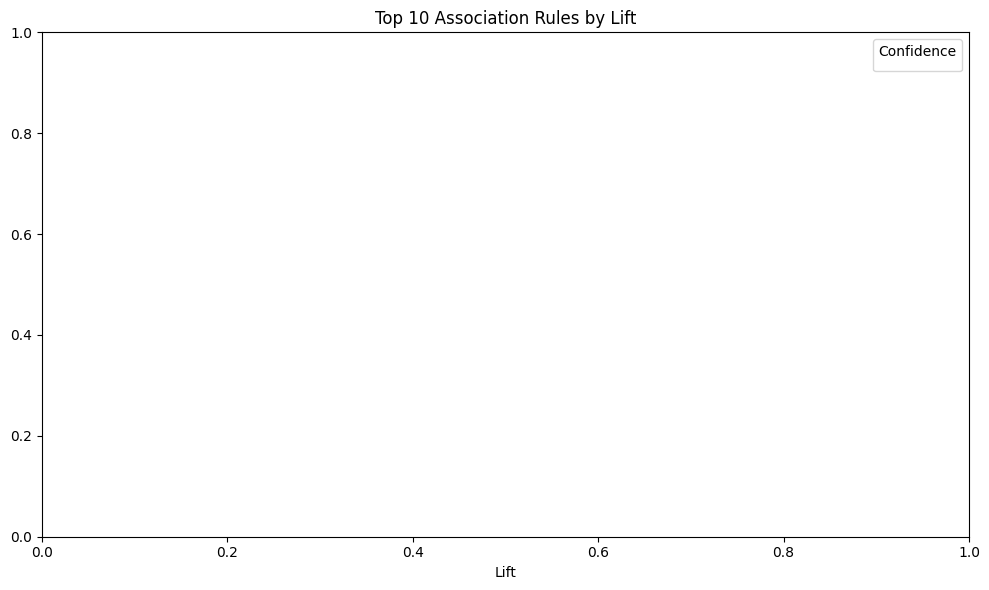

[END] Visualizing top-lift rules in 0.83 seconds


In [10]:
# 6. 可视化
@log_time("Visualizing top-lift rules")
def visualize_top_lift(rules, top_k=10):
    top_rules = rules.sort_values("lift", ascending=False).head(top_k)
    plt.figure(figsize=(10,6))
    sns.barplot(data=top_rules, x="lift", y=top_rules.index, hue="confidence", dodge=False)
    plt.title("Top 10 Association Rules by Lift")
    plt.xlabel("Lift")
    plt.legend(title="Confidence")
    plt.tight_layout()
    plt.savefig("top10_lift_rules.png")
    plt.show()

visualize_top_lift(rules)
